In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [2]:
import numpy as np
from scipy.stats import spearmanr,kendalltau,permutation_test,kstest
from skimage.measure import regionprops
import h5py
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import rf_analyze_func as rfaf
import analyze_func as af
import plot_func as pf

# Open Naive .mat File

In [25]:
naive_data = {}

with h5py.File('/Volumes/Seagate Portable Drive/Augusto Data/Naive_RF_Data_Share.mat', 'r') as f:
    print(f.keys())
    for key in ['LayerID', 'Off', 'On', 'Simple','Resps']:
        if key=='#refs#': continue
        val = f[key][()].flatten()
        if val.dtype=='object':
            naive_data[key] = [f[ref][()] for ref in val]
        else:
            naive_data[key] = val

<KeysViewHDF5 ['#refs#', 'Exps', 'Filt_Stims', 'LayerID', 'Off', 'On', 'Resps', 'Simple', 'Stims', 'StimsExps', 'StimsInEachSeed']>


In [41]:
reload(rfaf)

for data_id in range(len(naive_data['LayerID'])):
    pix_len = 100/naive_data['On'][data_id].shape[0]
    
    naive_data['On'][data_id] =\
        rfaf.z_score_RF(naive_data['On'][data_id],pix_len,25)
    naive_data['Off'][data_id] =\
        rfaf.z_score_RF(naive_data['Off'][data_id],pix_len,25)
    naive_data['Simple'][data_id] =\
        rfaf.z_score_RF(naive_data['Simple'][data_id],pix_len,25)

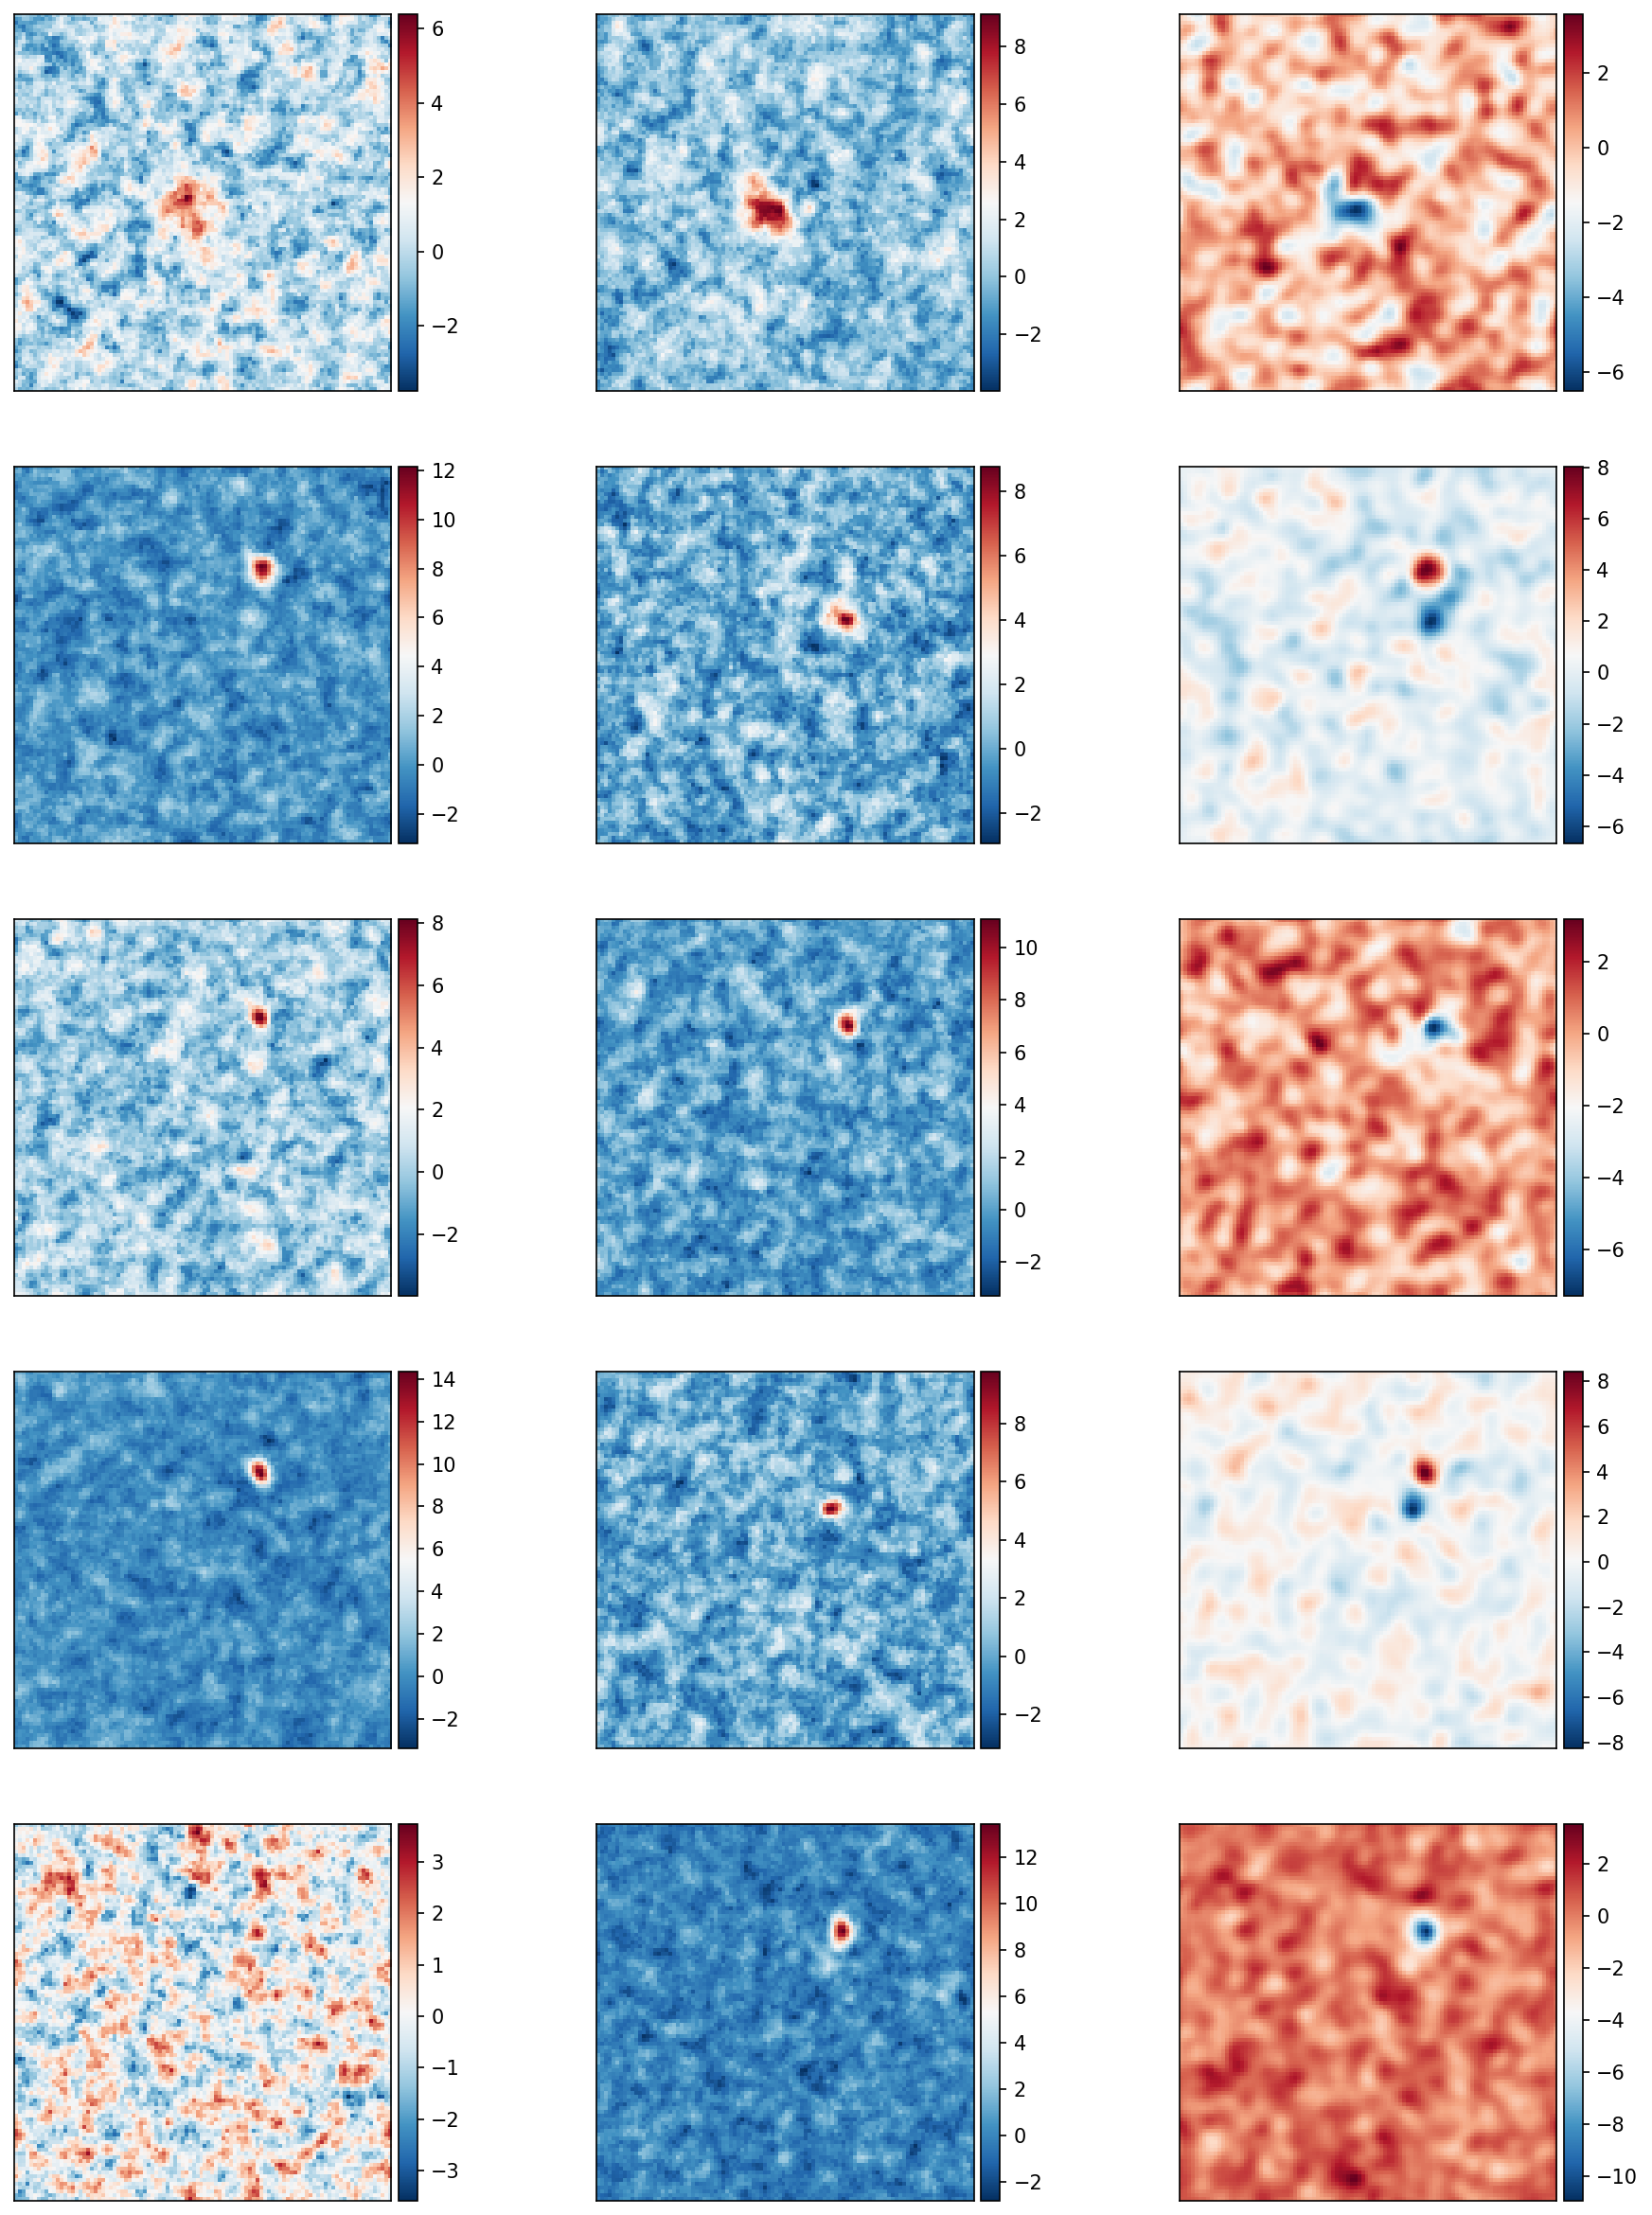

In [45]:
data_ids = np.arange(5)

fig,axs = plt.subplots(len(data_ids),3,figsize=(15,4*len(data_ids)),dpi=150)

for idx,data_id in enumerate(data_ids):
    pf.imshowbar(fig,axs[idx,0],naive_data['On'][data_id].T)
    pf.imshowbar(fig,axs[idx,1],naive_data['Off'][data_id].T)
    pf.imshowbar(fig,axs[idx,2],naive_data['Simple'][data_id].T)

In [67]:
N23 = np.count_nonzero(naive_data['LayerID']==1)
N4 = np.count_nonzero(naive_data['LayerID']==2)
N56 = np.count_nonzero(naive_data['LayerID']==3)

print(naive_data['LayerID'])
print('LayerID = 1 (L2/3):',N23)
print('LayerID = 2 (L4)  :',N4)
print('LayerID = 3 (L5/6):',N56)

[2. 1. 1. 1. 2. 2. 2. 2. 3. 3. 3. 2. 1. 3. 3. 1. 3. 2. 2. 3. 2. 2. 3. 1.
 1. 2. 2. 3. 3. 3. 1. 1. 2. 3. 3. 1. 1. 2. 3. 3. 3. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 3. 3. 3. 3. 3. 1. 2. 2. 1. 1. 1. 1. 2. 2. 3. 1. 1. 2. 3. 1. 1. 2.
 2. 1. 1. 2. 2. 2. 3.]
LayerID = 1 (L2/3): 22
LayerID = 2 (L4)  : 33
LayerID = 3 (L5/6): 24


In [167]:
reload(rfaf)

sig_cutoff = 2.5

L23_data = {'SR_ON': [],
            'SR_OF': [],
            'RF_ON': [],
            'RF_OF': []}
L4_data =  {'SR_ON': [],
            'SR_OF': [],
            'RF_ON': [],
            'RF_OF': []}
L56_data = {'SR_ON': [],
            'SR_OF': [],
            'RF_ON': [],
            'RF_OF': []}

for idx,layer in enumerate(naive_data['LayerID']):
    n = naive_data['On'][idx].shape[0]
    pix_len = 100/n
    
    this_SR_ON,this_SR_OF = rfaf.binary_clean_RF((naive_data['On'][idx] > sig_cutoff).astype(int),
                                                 (naive_data['Off'][idx]> sig_cutoff).astype(int),
                                                 pix_len)
    this_RF_ON,this_RF_OF = rfaf.binary_clean_RF((naive_data['Simple'][idx] > sig_cutoff).astype(int),
                                                 (naive_data['Simple'][idx] <-sig_cutoff).astype(int),
                                                 pix_len)
    this_SR_ON,this_SR_OF = rfaf.center_rescale_RF((naive_data['On'][idx] > sig_cutoff).astype(int),
                                                   (naive_data['Off'][idx]> sig_cutoff).astype(int),
                                                   pix_len,rfaf.find_cent_idx(this_SR_ON+this_SR_OF),
                                                   32,30,0.5)
    this_RF_ON,this_RF_OF = rfaf.center_rescale_RF((naive_data['Simple'][idx] > sig_cutoff).astype(int),
                                                   (naive_data['Simple'][idx] <-sig_cutoff).astype(int),
                                                   pix_len,rfaf.find_cent_idx(this_RF_ON+this_RF_OF),
                                                   32,30,0.5)
    if layer==1:
        this_dict = L23_data
    elif layer==2:
        this_dict = L4_data
    else:
        this_dict = L56_data
    
    this_dict['SR_ON'].append(this_SR_ON)
    this_dict['SR_OF'].append(this_SR_OF)
    this_dict['RF_ON'].append(this_RF_ON)
    this_dict['RF_OF'].append(this_RF_OF)

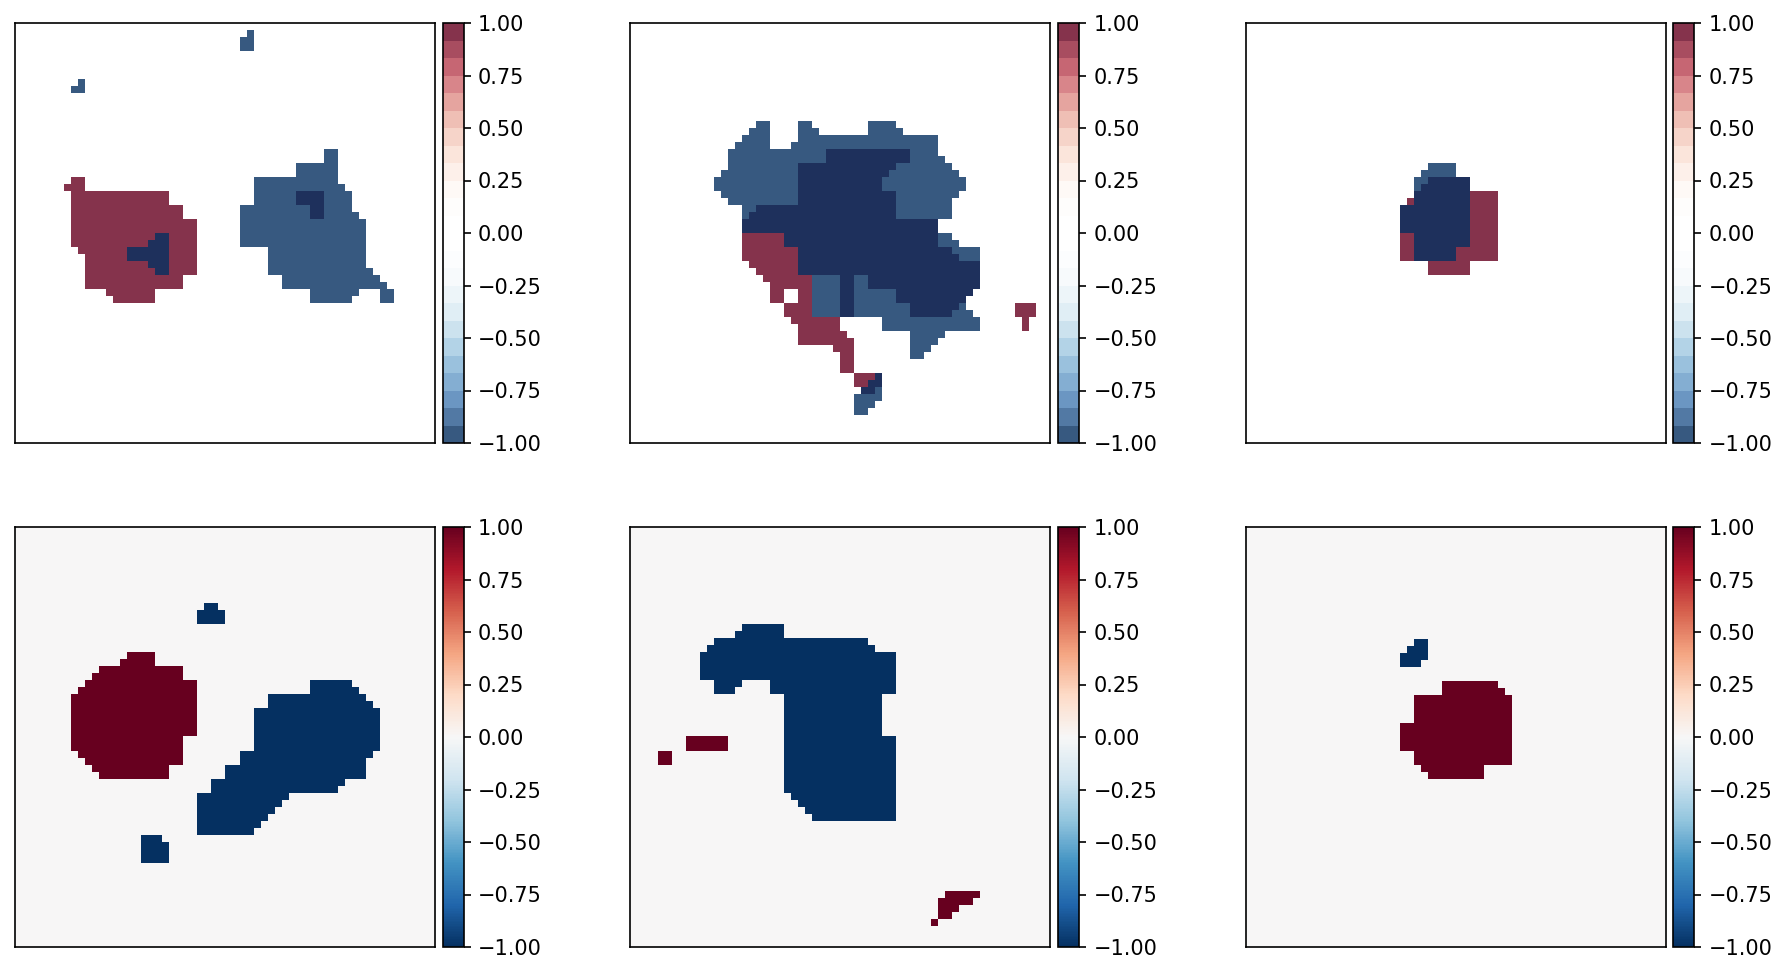

In [168]:
data_ids = [0,0,0]

fig,axs = plt.subplots(2,3,figsize=(15,8),dpi=150)

for idx,Ldict in enumerate([L23_data,L4_data,L56_data]):
    pf.doubimshbar(fig,axs[0,idx],Ldict['SR_ON'][data_ids[idx]],
                   -Ldict['SR_OF'][data_ids[idx]],vmin=-1,vmax=1)
    pf.imshowbar(fig,axs[1,idx],Ldict['RF_ON'][data_ids[idx]]-\
                 Ldict['RF_OF'][data_ids[idx]],vmin=-1,vmax=1)

In [169]:
for Ldict,Lsize in zip([L23_data,L4_data,L56_data],[N23,N4,N56]):
    this_sepr = np.zeros(Lsize)
    this_bias = np.zeros(Lsize)
    this_dist = np.zeros(Lsize)
    this_onar = np.zeros(Lsize)
    this_ofar = np.zeros(Lsize)
    this_totar = np.zeros(Lsize)
    
    for idx in range(Lsize):
        this_SR_ON = Ldict['SR_ON'][idx]
        this_SR_OF = Ldict['SR_OF'][idx]
        
        this_sepr[idx] = 1-np.abs((this_SR_ON+this_SR_OF)==2).sum((-2,-1)) /\
            np.fmin(this_SR_ON.sum((-2,-1)),this_SR_OF.sum((-2,-1)))
        if np.isnan(this_sepr[idx]):
            this_sepr[idx] = 1
        this_bias[idx] = np.abs((this_SR_ON-this_SR_OF).sum((-2,-1))) /\
            (this_SR_ON+this_SR_OF).sum((-2,-1))
        if np.sum(this_SR_ON)*0.25 > 15:
            props = regionprops(this_SR_ON)[0]
            on_cent = props['centroid']
        else:
            on_cent = [np.nan,np.nan]
        if np.sum(this_SR_OF)*0.25 > 15:
            props = regionprops(this_SR_OF)[0]
            of_cent = props['centroid']
        else:
            of_cent = [np.nan,np.nan]
        this_dist[idx] = np.sqrt((on_cent[0]-of_cent[0])**2+(on_cent[1]-of_cent[1])**2)*0.5
        this_onar[idx] = this_SR_ON.sum((-2,-1))*0.25
        this_ofar[idx] = this_SR_OF.sum((-2,-1))*0.25
        this_totar[idx] = this_onar[idx] + this_ofar[idx]
    
    Ldict['sepr'] = this_sepr
    Ldict['bias'] = this_bias
    Ldict['dist'] = this_dist
    Ldict['onar'] = this_onar
    Ldict['ofar'] = this_ofar
    Ldict['totar'] = this_totar

/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_40335/5032507.py:13: RuntimeWarning: invalid value encountered in scalar divide
  this_sepr[idx] = 1-np.abs((this_SR_ON+this_SR_OF)==2).sum((-2,-1)) /\


In [170]:
noris = 8
nphss = 16

freq = 0.06

grates = np.zeros((noris,nphss,60,60))

xs,ys = np.meshgrid(np.arange(60)*0.5,np.arange(60)*0.5)

for i in range(noris):
    ori = i/noris*np.pi
    for j in range(nphss):
        phs = j/nphss*2*np.pi
        grates[i,j] = np.heaviside(np.cos(phs+2*np.pi*freq*(np.cos(ori)*xs+np.sin(ori)*ys)),0.5)

In [171]:
for Ldict,Lsize in zip([L23_data,L4_data,L56_data],[N23,N4,N56]):
    this_SR_resp = [None]*Lsize
    
    for idx in range(Lsize):
        this_SR_ON = Ldict['SR_ON'][idx]
        this_SR_OF = Ldict['SR_OF'][idx]

        this_SR_resp[idx] = np.sum(grates*this_SR_ON[None,None,:,:]+\
                            (1-grates)*this_SR_OF[None,None,:,:],(-2,-1))
        this_SR_resp[idx] = np.fmax(0,this_SR_resp[idx] - np.mean(this_SR_resp[idx]))
    
    this_SR_resp = np.array(this_SR_resp)
    this_SR_OS,this_SR_MR = af.calc_OS_MR(this_SR_resp)
    
    Ldict['SR_resp'] = this_SR_resp
    Ldict['SR_OS'] = this_SR_OS
    Ldict['SR_MR'] = this_SR_MR

In [172]:
print(np.nanmax(np.concatenate([L23_data['dist'],L4_data['dist'],L56_data['dist']])))
print(np.nanmax(np.concatenate([L23_data['totar'],L4_data['totar'],L56_data['totar']])))

14.099998371949171
338.5


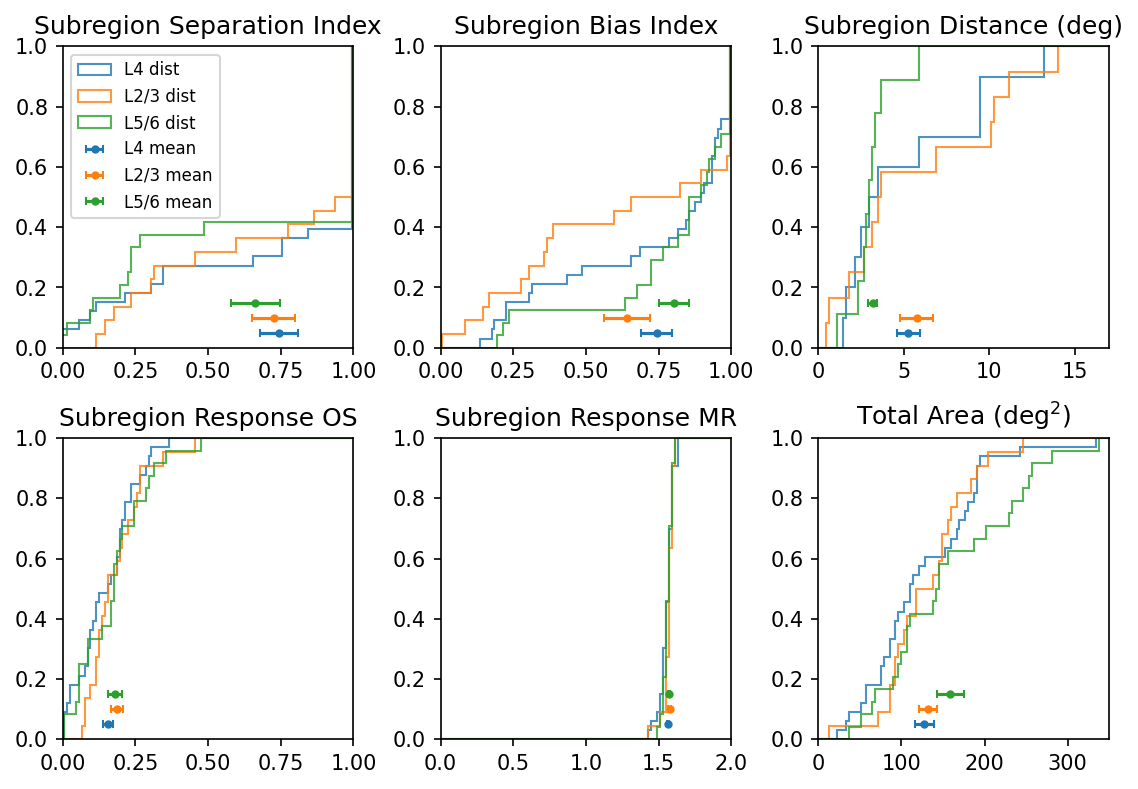

In [173]:
nbins = 100

fig,axs = plt.subplots(2,3,figsize=(9,6),dpi=150)
fig.subplots_adjust(wspace=0.3,hspace=0.3)
axs = axs.ravel()

for col_idx,key,data_max,col_label in zip(range(6),['sepr','bias','dist','SR_OS','SR_MR','totar'],
                                          [1,1,17,1,2,350],
                                          ['Subregion Separation Index','Subregion Bias Index',
                                           'Subregion Distance (deg)','Subregion Response OS',
                                           'Subregion Response MR',r'Total Area (deg${}^2$)']):
    for Lidx,Ldict,Lsize,Llabel in zip(range(3),[L4_data,L23_data,L56_data],[N4,N23,N56],
                                       ['L4','L2/3','L5/6']):
        axs[col_idx].hist(Ldict[key],np.linspace(-data_max/(2*nbins),data_max+data_max/(2*nbins),2+nbins),
                                  density=True,cumulative=True,histtype='step',
                                  color='C{:d}'.format(Lidx),alpha=0.8,label=Llabel+' dist')

        axs[col_idx].errorbar(np.nanmean(Ldict[key]),(Lidx+1)*0.05,
                              xerr=np.nanstd(Ldict[key])/np.sqrt(Lsize-1),
                              color='C{:d}'.format(Lidx),fmt='.',capsize=2,label=Llabel+' mean')
    
    axs[col_idx].set_xlim(0,data_max)
    axs[col_idx].set_ylim(0,1)
    axs[col_idx].set_title(col_label)
    
axs[0].legend(fontsize=8)

In [174]:
print('L4   vs L2/3 Separation:',kstest( L4_data['sepr'],L23_data['sepr']))
print('L4   vs L5/6 Separation:',kstest( L4_data['sepr'],L56_data['sepr']))
print('L2/3 vs L5/6 Separation:',kstest(L23_data['sepr'],L56_data['sepr']))
print()
print('L4   vs L2/3 Bias:',kstest( L4_data['bias'],L23_data['bias']))
print('L4   vs L5/6 Bias:',kstest( L4_data['bias'],L56_data['bias']))
print('L2/3 vs L5/6 Bias:',kstest(L23_data['bias'],L56_data['bias']))
print()
print('L4   vs L2/3 Distance:',kstest( L4_data['dist'],L23_data['dist']))
print('L4   vs L5/6 Distance:',kstest( L4_data['dist'],L56_data['dist']))
print('L2/3 vs L5/6 Distance:',kstest(L23_data['dist'],L56_data['dist']))
print()
print('L4   vs L2/3 Area:',kstest( L4_data['totar'],L23_data['totar']))
print('L4   vs L5/6 Area:',kstest( L4_data['totar'],L56_data['totar']))
print('L2/3 vs L5/6 Area:',kstest(L23_data['totar'],L56_data['totar']))
print()
print('L4   vs L2/3 OS:',kstest( L4_data['SR_OS'],L23_data['SR_OS']))
print('L4   vs L5/6 OS:',kstest( L4_data['SR_OS'],L56_data['SR_OS']))
print('L2/3 vs L5/6 OS:',kstest(L23_data['SR_OS'],L56_data['SR_OS']))
print()
print('L4   vs L2/3 MR:',kstest( L4_data['SR_MR'],L23_data['SR_MR']))
print('L4   vs L5/6 MR:',kstest( L4_data['SR_MR'],L56_data['SR_MR']))
print('L2/3 vs L5/6 MR:',kstest(L23_data['SR_MR'],L56_data['SR_MR']))

L4   vs L2/3 Separation: KstestResult(statistic=0.15151515151515152, pvalue=0.8954689286434623, statistic_location=0.11864406779661019, statistic_sign=1)
L4   vs L5/6 Separation: KstestResult(statistic=0.19318181818181818, pvalue=0.5975563860458432, statistic_location=0.2666666666666667, statistic_sign=-1)
L2/3 vs L5/6 Separation: KstestResult(statistic=0.19318181818181818, pvalue=0.7059605739395262, statistic_location=0.2666666666666667, statistic_sign=-1)

L4   vs L2/3 Bias: KstestResult(statistic=0.19696969696969696, pvalue=0.6397280568063332, statistic_location=0.38636363636363635, statistic_sign=-1)
L4   vs L5/6 Bias: KstestResult(statistic=0.14772727272727273, pvalue=0.8729993668585233, statistic_location=0.4896373056994819, statistic_sign=1)
L2/3 vs L5/6 Bias: KstestResult(statistic=0.3333333333333333, pvalue=0.11762976853510283, statistic_location=0.657516339869281, statistic_sign=1)

L4   vs L2/3 Distance: KstestResult(statistic=0.24242424242424243, pvalue=0.38110876299826396,

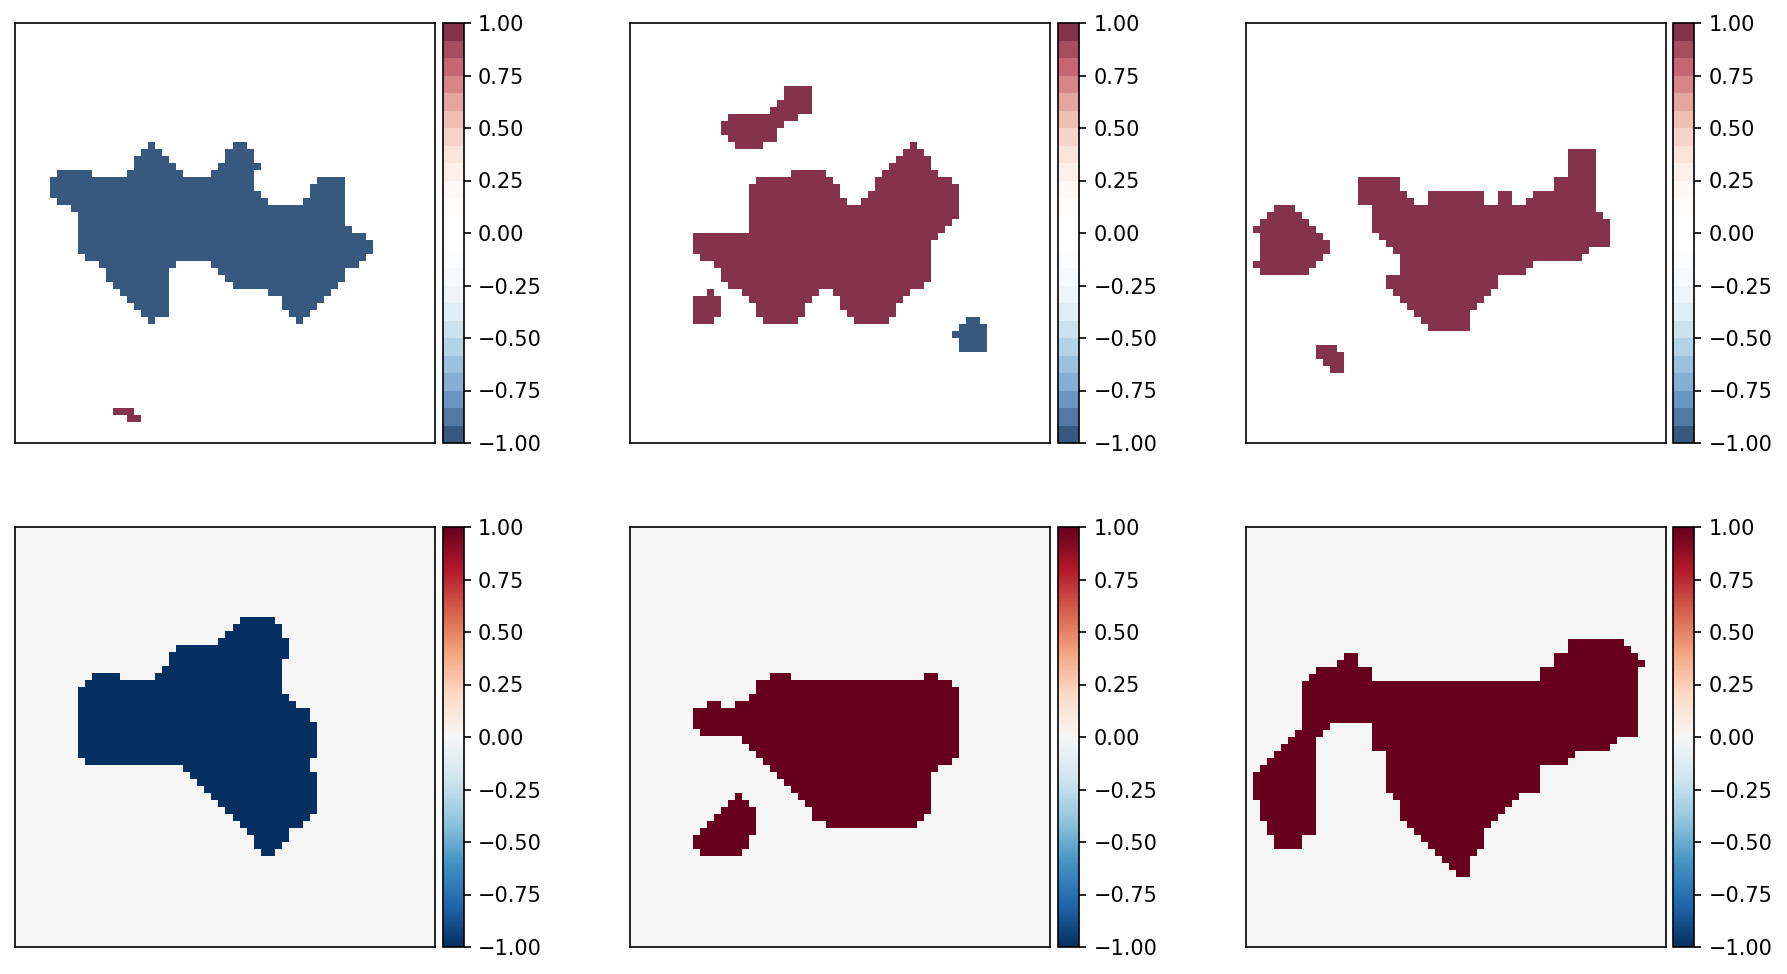

In [175]:
fig,axs = plt.subplots(2,3,figsize=(15,8),dpi=150)

for idx,Ldict in enumerate([L23_data,L4_data,L56_data]):
    data_id = np.argmax(Ldict['SR_OS'])
    pf.doubimshbar(fig,axs[0,idx],Ldict['SR_ON'][data_id],
                   -Ldict['SR_OF'][data_id],vmin=-1,vmax=1)
    pf.imshowbar(fig,axs[1,idx],Ldict['RF_ON'][data_id]-\
                 Ldict['RF_OF'][data_id],vmin=-1,vmax=1)